## Ridge Regression ##

The following script contains two main parts; The first creates a clean and rescaled dataset with rents per hour left-joined on the available temperatures per hour for 2019. The second part creates a ridge model and visualize the regression/prediction.

Coefficients  [ 0.00000000e+00  3.54258106e+02 -3.91002641e+02  1.41790685e+02
 -2.36965070e+01  2.09907953e+00 -1.01812222e-01  2.55409670e-03
 -2.59214317e-05] 
Intercept  34.46727833850093


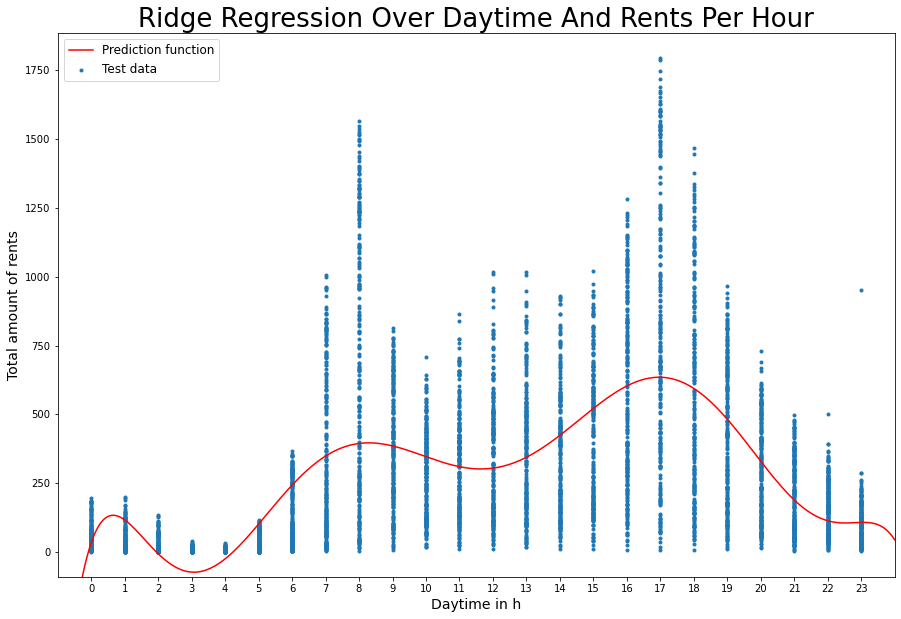

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Import data from previous results and create DataFrame objects
Weather = pd.read_csv('weather_hourly_boston.csv', sep=',')
Rents = pd.read_csv('KPI_total_rents_per_hour.csv', sep=',')
df_rents = pd.DataFrame(Rents)
df_weather = pd.DataFrame(Weather)

# Clean the weather dataset and get data for 2019 only
df_weather = df_weather.dropna()
begin_2019 = pd.to_datetime('2019-01-01 00:00')
end_2019 = pd.to_datetime('2019-12-31 23:00')
times = pd.to_datetime(df_weather.date_time)
df_weather_2019 = df_weather.loc[(times.dt.year >= 2019) & (times.dt.year <= 2019)]
df_weather_2019 = df_weather_2019.reset_index()
df_weather_2019 = df_weather_2019.set_index('date_time')

# Create the combined dataset. Do a left-join on weather dataset timestamps.
df_weather_2019.index = df_weather_2019.index.rename('hour')
df_weather_and_rents = pd.merge(df_weather_2019,df_rents,on='hour',how='left')
df_weather_and_rents = df_weather_and_rents.drop_duplicates(subset=['hour'], keep='first')
df_weather_and_rents = df_weather_and_rents.dropna()
df_weather_and_rents = df_weather_and_rents.sort_values(by=['hour'])
df_weather_and_rents = df_weather_and_rents.drop('index', axis='columns')
df_weather_and_rents['avg_temp'] = (df_weather_and_rents['max_temp'] + df_weather_and_rents['min_temp'])/2
df_weather_and_rents = df_weather_and_rents.drop(['min_temp','max_temp'], axis='columns')

df_weather_and_rents['datetime'] = df_weather_and_rents['hour']
df_weather_and_rents.drop('hour', axis = 1)

#prepare the data
df = pd.DataFrame(df_weather_and_rents['datetime'])

times = pd.to_datetime(df.datetime)
dailyData = pd.DataFrame(times)
dailyData["hour"] = times.dt.hour
dailyData["weekday"] = times.dt.weekday
dailyData["month"] = times.dt.month
df_weather_and_rents['hour'] = dailyData['hour']
df_weather_and_rents['weekday'] = dailyData['weekday']
df_weather_and_rents['month'] = dailyData['month']
train, test = train_test_split(df_weather_and_rents, test_size = 0.7, random_state = 42)

# Make train and test sets
X_train = train['hour']
X_test = test['hour']
y_train = train['rents_count']
y_test = test['rents_count']

# initialize model
Poly = PolynomialFeatures(degree = 8)

# fit and transform X_train
X_poly = Poly.fit_transform(X_train.values.reshape(-1,1))

# Construct Ridge Regression with alpha = 0 and normalization
ridgeModel = Ridge(alpha = 0, normalize = True)

# Make prediction
ridgeModel.fit(X_poly, y_train.values)
prediction = ridgeModel.predict(X_poly)

# Print information
print("Coefficients ", ridgeModel.coef_, "\nIntercept ", ridgeModel.intercept_ )

# Plot test data and prediction function
min_x, max_x = X_test.min(), X_test.max()
xt0 = np.linspace(min_x-1, max_x+1, 400)
xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
plt.figure(figsize = (15,10))
plt.scatter(X_test, y_test, marker=".", label = 'Test data')
ylim = plt.ylim()
plt.plot(xt0, ridgeModel.predict(xt0_poly), 'C1', color='red', label = 'Prediction function')
plt.xlabel("Daytime in h", fontsize = 14)
plt.ylabel("Total amount of rents", fontsize = 14)
plt.xlim([min_x-2, max_x+2])
plt.ylim(ylim)
plt.xlim([-1,24])
plt.xticks(np.arange(0, 24))
plt.title('Ridge Regression Over Daytime And Rents Per Hour', fontsize=26)
plt.legend(fontsize=12, loc='upper left')

# Save the picture as PNG and PDF file
plt.savefig('RidgeRegression.pdf', dpi=300)
plt.savefig('RidgeRegression.png', dpi=300)

# Show results
plt.show()